## Motivation

In the experiment designed to test the independency of cell fate decisions in the ICM (see main text and Figure 1), we mix wild type embyro cells labelled with H2B-GFP and unlabelled cells (either wild type or Gata6 null). The presence (or absence) of GFP lets us identify the progeny of each subpopulation (GFP+, GFP-). 
Given that either population can represent any given fraction of the resulting chimeric embryo, manual scoring of GFP+ and GFP- cells becomes unreasonable, and therefore we automated the task. GFP expression is variable due to mosaic expression of the transgene and to the noise in the image acquisition and  processing. For these reasons a simple threshold is not enough to accurately separate populations. Instead, we use clustering methods, which give a better result.  

In this notebook, I compare the performance of three approaches, Hierarchical clustering, 1D and 2D K-means clustering, and show the rationale for the approach we ultimately used in the study.

### Set up
Load necessary packages and create an object with plotting aesthetics

In [4]:
library('reshape2')
library('plyr')
library('dplyr')
library('ggplot2')

source('../src/plotting-aes.R')

### Load data

Read in transformed and corrected data for the chimeras experiments

In [2]:
g6.chimeras <- read.csv('../data/processed/emb-xim-processed.csv')

### First look  

Let's first generate a plot showing the distribution of GFP levels for all embryos at the end of the experiment (after 48h in culture). Below we will plot some density distributions showing GFP levels on the X axis, one curve for each embryo. Embryos are grouped by litter and treatment: 
   * **control** embryos (100% cells either GFP+ or GFP-) are shown as black lines 
   * **chimeric** embryos (different fractions of GFP+ and GFP- cells) are shown as green lines

Each panel is labeled with letters indicating the litter and a number that indicates the initial % of GFP+ cells at the time of making the chimera.

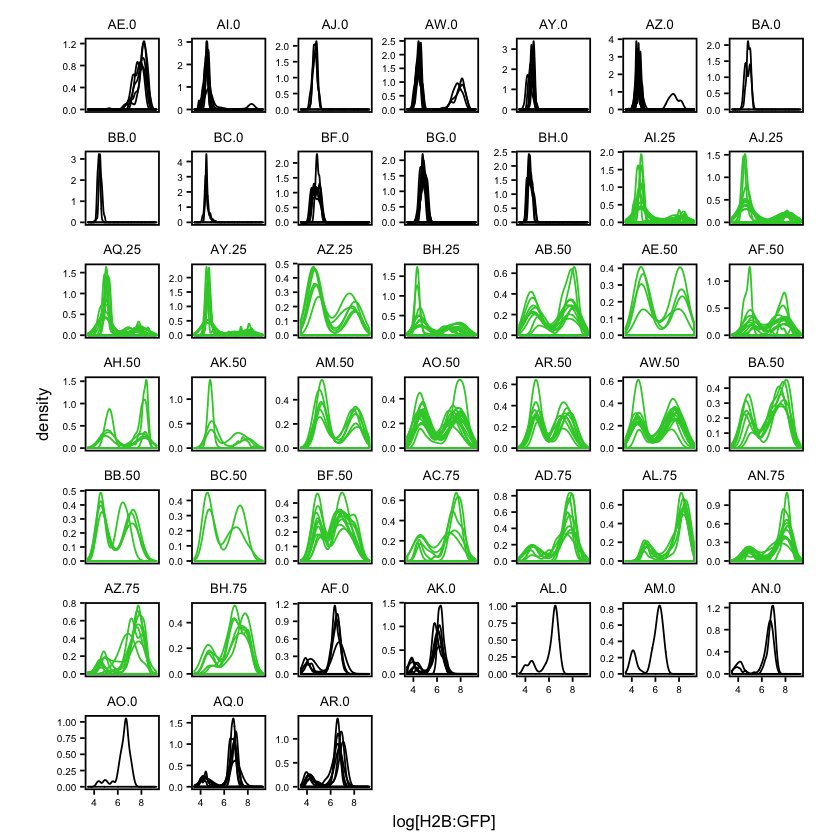

In [3]:
curves <- ggplot(data = g6.chimeras %>% filter(Channel == 'CH2', 
                                               CH2.ab2 == 'af488.ck'))
for(e in unique(g6.chimeras$Embryo_ID)){
        curves <- curves + geom_density(data = g6.chimeras %>%
                                                filter(Treatment == 'Chimera',
                                                       Channel == 'CH2',
                                                       Embryo_ID == e),
                                        aes(x = CH2.logCor),
                                        color = '#33cc33', alpha = 0.5)
        curves <- curves + geom_density(data = g6.chimeras %>%
                                                filter(Treatment == 'Control',
                                                       Channel == 'CH2',
                                                       Embryo_ID == e),
                                        aes(x =  CH2.logCor),
                                        color = 'black', alpha = 0.5)
}
curves <- curves + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 8), 
                                 axis.text = element_text(size = 6), 
                                 axis.title = element_text(size = 10))
curves <- curves + labs(x = 'log[H2B:GFP]')
curves <- curves + facet_wrap( ~ reorder(interaction(Litter, t0.donor), 
                                         t0.donor), scales = 'free_y')
print(curves)

As one might expect, chimeras show bimodal distributions of GFP levels, corresponding to GFP- and GFP+ cells, and the height of the peaks roughly agrees with the initial fraction of GFP- and GFP+ cells in the group (for instance, compare AR.50, which had 50% GFP+, 50% GFP- at the start, with AL.75, which had 25% GFP- and 75% GFP+ at the start).

### Uncertainty

Given the bimodal distribution we could just split both peaks using clustering along one dimension (H2B-GFP levels). However, for most embryos, it is not a clean division - there is always a fraction of cells with intermediate GFP levels. This becomes quite obvious if we plot embryos separately for one given litter:

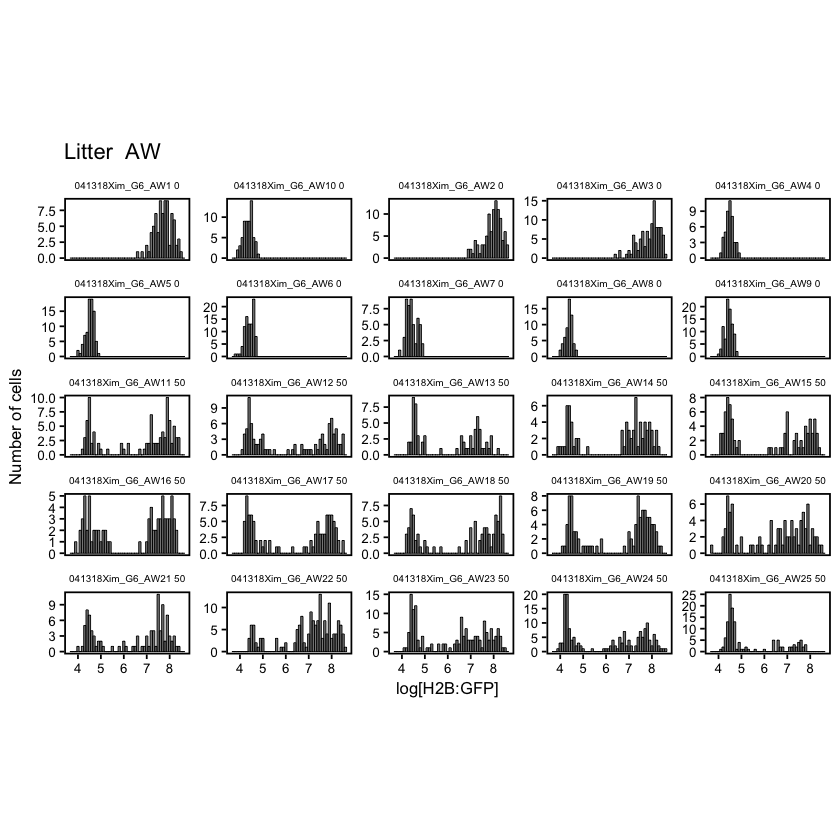

In [4]:
# Choose an example litter
my.litter <- 'AW'

# Plot histogram
histos <- ggplot(data = g6.chimeras %>% 
                 filter(Litter == my.litter,
                        Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'),
                 aes(x = CH2.logCor))
        histos <- histos + geom_histogram(color = 'black', binwidth = 0.1, 
                                          alpha = 0.75, size = 0.25)
        histos <- histos + looks 
        histos <- histos + labs(x = 'log[H2B:GFP]', y = 'Number of cells', 
                                title = paste('Litter ', my.litter))
        histos <- histos + facet_wrap( ~ reorder(paste(Embryo_ID, t0.donor), 
                                      t0.donor), scales = 'free_y')
        histos <- histos + theme(aspect.ratio = 1/2, 
                                 strip.text = element_text(size = 6), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
        print(histos)

While in some chimeras (AW14, AW15) the separation between GFP+ and GFP- is very evident, for others, like AW20, or AW23, there are a few cells with intermediate levels.  

This is an error we can live with for chimeras in which both subpopulations are wild type. However, this can be problematic in chimeras where the GFP- cells are *Gata6-/-*. In those experiments, GFP+ cells (wild type) erroneously classified as GFP- (*Gata6* null) could be Primitive Endoderm, a cell type that *Gata6-/-* embryos cannot make. Therefore, it is worth to try and get the best classification possible (spoiler: *it won't be perfect...*).  

Let's then better separate cells introducing a second dimension, like the nuclear label we use, Hoechst:

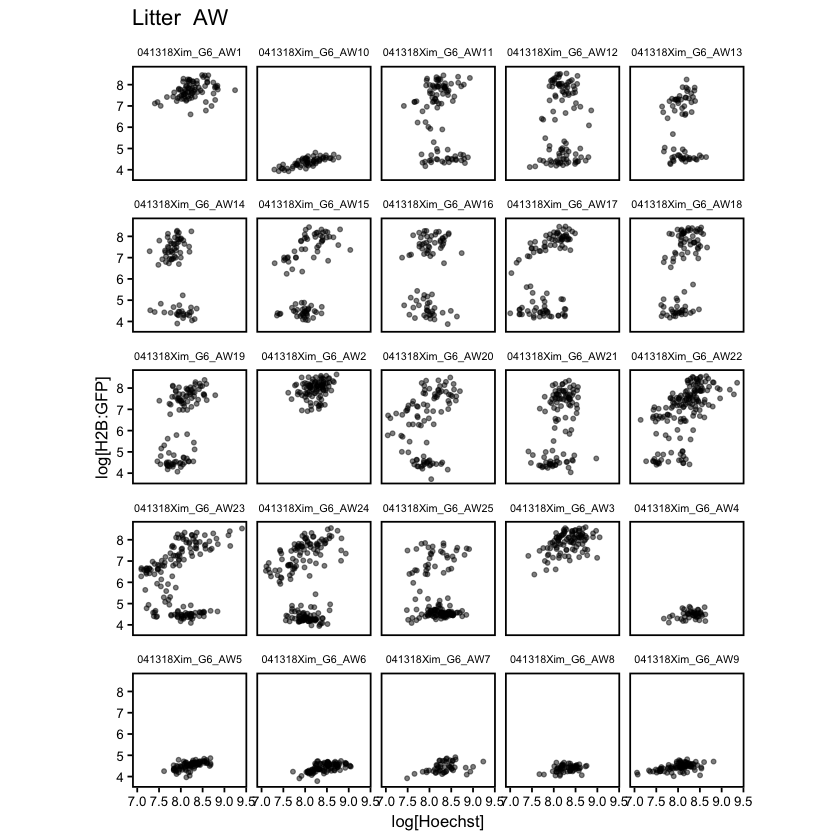

In [5]:
scatter <- ggplot(data = g6.chimeras %>% 
                 filter(Litter == my.litter,  
                        Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'), 
                  aes(x = CH1.ebLogCor, 
                      y = CH2.logCor))
scatter <- scatter + geom_jitter(size = 1, alpha = 0.5)
scatter <- scatter + facet_wrap( ~ Embryo_ID)
scatter <- scatter + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 6.5), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
scatter <- scatter + labs(y = 'log[H2B:GFP]', x = 'log[Hoechst]', 
                                title = paste('Litter ', my.litter))
print(scatter)

Now, it is easier to tell where the intermediate cells belong, at least for some embryos (like AW18 or 19).

### K-means clustering  

Let's try to separate the two clusters in chimeras using K-means clustering and the same litter as above (AW) as an example. In control embryos there is no need to classify, as all cells are the same (either GFP+ or GFP-). In order to have robust clustering, we  run the algorithm on each litter (experiment) separately, but for all embryos in one litter together. Each litter was processed and imaged at once, therefore most variation within each litter should be biological, whereas variation between litters should mostly be technical. 

In this example we only do it for litter AW to illustrate this point and save time

In [33]:
# Split dataset into Control embryos (100% host) and chimeras (mix of host and donor cells)
cc <- subset(g6.chimeras, Treatment == 'Control')
xs <- subset(g6.chimeras, Treatment == 'Chimera')

# Classify all control cells as 'host'
cc$cell_type <- 'host'

In [34]:
# Choose an example litter
my.litter <- 'AW'

# Extract it from the chimeras dataset
aw <- subset(xs, Litter == my.litter)

In [35]:
# Select only CH1 (Hoechst) and CH2 (GFP) to do clustering
bb <- aw %>% select(Cellcount, CH1.ebLogCor, CH2.logCor)
# Run K-means, looking for 2 clusters (GFP+ and GFP- cells)
kk <- kmeans(bb[, 2:3], 2)
print(kk$centers)

  CH1.ebLogCor CH2.logCor
1     8.094229   7.515522
2     8.015084   4.596424


In [36]:
# Calculate the sum of squares of the difference between 
# values and cluster centers
ssq <- matrix(0, length(aw$TE_ICM), 2)
for(i in 1:2) {
    ssq[,i] <- (aw$CH1.ebLogCor - kk$centers[i,1])^2 +
                (aw$CH2.logCor - kk$centers[i,2])^2
}
min.ssq <- apply(ssq, 1, which.min)
# Classify cells as 'donor' (GFP+) or 'host' (GFP-)
aw$cell_type <- rep(NA, nrow(aw))
aw$cell_type <- c('donor', 'host')[min.ssq]

In [37]:
# Incorporate AW controls
aw <- rbind(aw, subset(cc, Litter == 'AW'))

Below is the same scatter plot as earlier, with cells colored in green (GFP+) or gray (GFP-) depending on the group they were assigned to by K-means

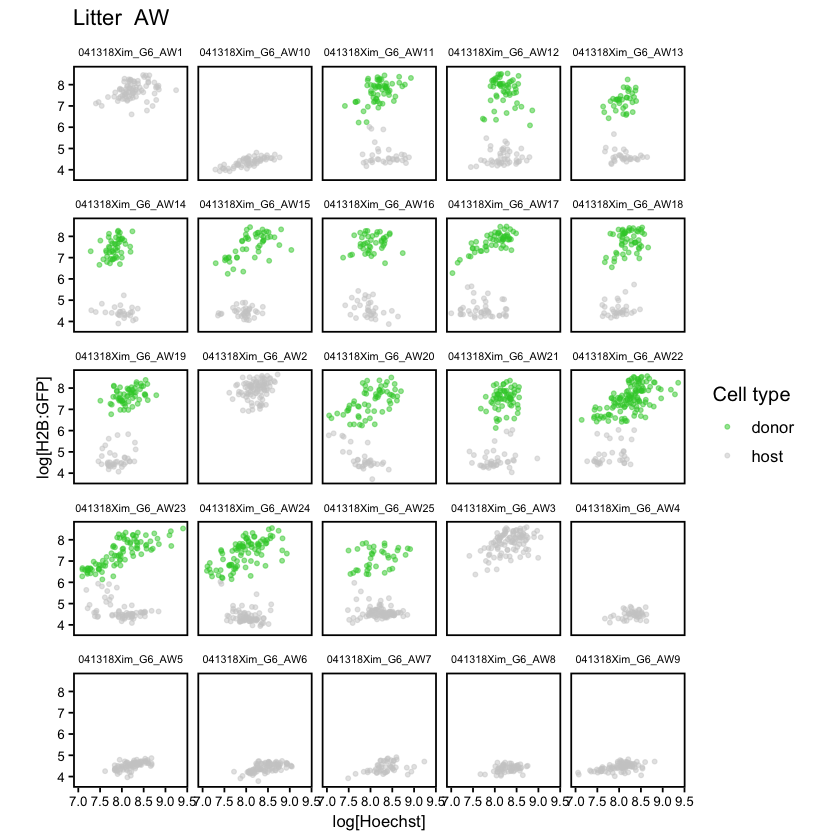

In [40]:
scatter <- ggplot(data = aw %>% 
                 filter(Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'), 
                  aes(x = CH1.ebLogCor, 
                      y = CH2.logCor))
scatter <- scatter + geom_jitter(aes(color = cell_type), size = 1, alpha = 0.5)
scatter <- scatter + facet_wrap( ~ Embryo_ID)
scatter <- scatter + scale_color_manual(values = cellcols)
scatter <- scatter + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 6.5), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
scatter <- scatter + labs(y = 'log[H2B:GFP]', x = 'log[Hoechst]', 
                                title = paste('Litter ', my.litter), color = 'Cell type')
print(scatter)

### Hierarchical clustering

Although K-means does a reasonable job at classifying, I found that Hierarchical Clustering performed slightly better, after manually inspecting some of the troublesome embryos with many intermediate cells. I also decided to use Hierarchical clustering here for consistency, since it is the method I use to classify cell populations as PrE, epiblast, etc., based on transcription factor levels (see the H-clustering notebook), and also because it is simpler to code.

Let's do the same process as above using Hierarchical Clustering for litter AW

In [56]:
# Once again, extract an example litter from the chimeras dataset
my.litter <- 'AW'

# Extract it from the chimeras dataset
aw <- subset(xs, Litter == my.litter)

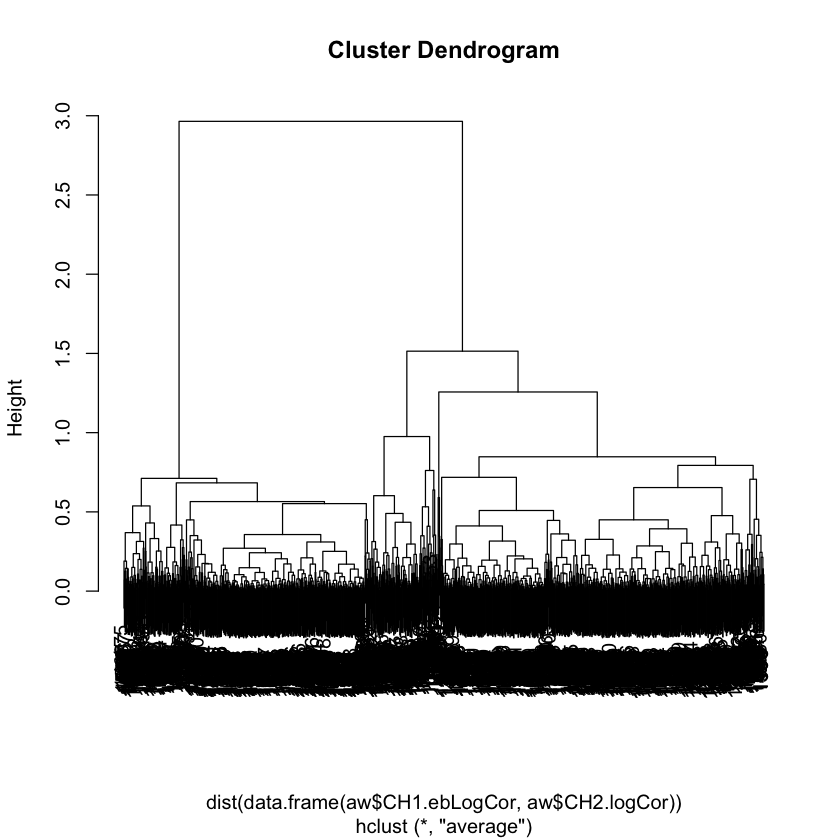

In [57]:
# Run the hclust() function to perform Hierarchical Clustering 
# on channels 1 and 2 of aw using the UPGMA method and plot the dendrogram

my.clusters <- hclust(dist(data.frame(aw$CH1.ebLogCor, aw$CH2.logCor)), 
                      method = 'average')
plot(my.clusters)

The dendrogram shows two main clusters, presumably GFP+ and GFP-, so let's cut it at that level and assign cells to each of them

In [58]:
# Use cutree to cut the dendrogram at the indicated number of clusters
aw$cluster <- cutree(my.clusters, 2)

# Assign donor or host labels to each cluster based on its GFP level
bigger <- mean(subset(aw, cluster == 2)$CH2.logCor) - 
    mean(subset(aw, cluster == 1)$CH2.logCor) > 0
if (bigger == T) {
    aw$cell_type[aw$cluster == 2] <- 'donor'
    aw$cell_type[aw$cluster == 1] <- 'host'
}
if (bigger == F) {
    aw$cell_type[aw$cluster == 2] <- 'host'
    aw$cell_type[aw$cluster == 1] <- 'donor'
}

In [59]:
# Incorporate AW controls
aw$cluster <- NULL
aw <- rbind(aw, subset(cc, Litter == 'AW'))

And let's make the same plot again

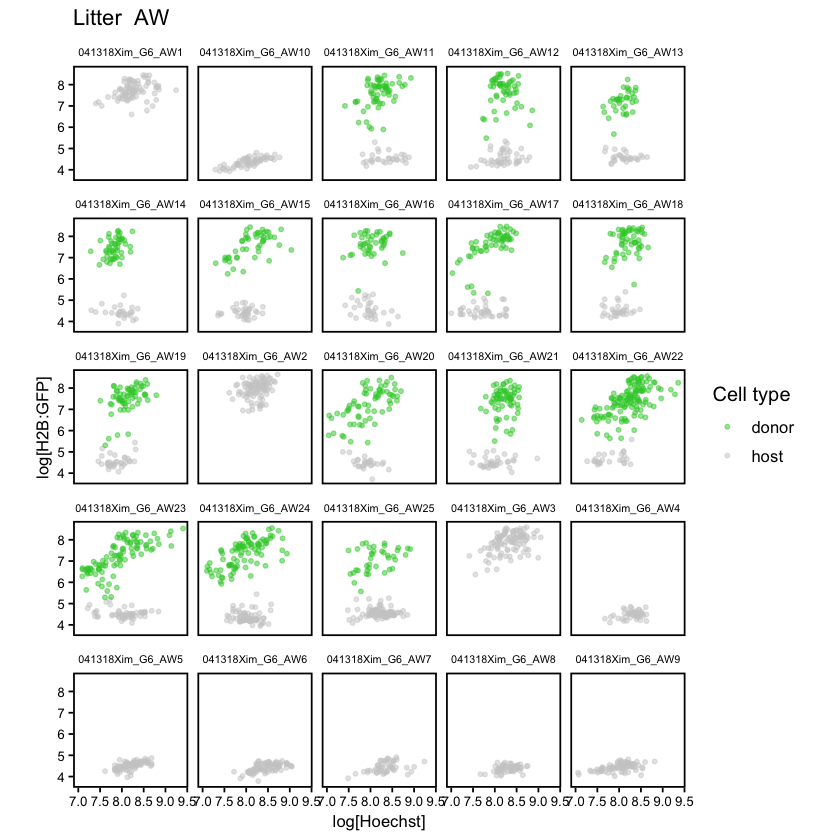

In [60]:
scatter <- ggplot(data = aw %>% 
                 filter(Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'), 
                  aes(x = CH1.ebLogCor, 
                      y = CH2.logCor))
scatter <- scatter + geom_jitter(aes(color = cell_type), size = 1, alpha = 0.5)
scatter <- scatter + facet_wrap( ~ Embryo_ID)
scatter <- scatter + scale_color_manual(values = cellcols)
scatter <- scatter + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 6.5), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
scatter <- scatter + labs(y = 'log[H2B:GFP]', x = 'log[Hoechst]', 
                                title = paste('Litter ', my.litter), color = 'Cell type')
print(scatter)

Although globally the result is similar, in embryos with many intermediate cells, like AW20-AW23, they are picked up as GFP+, which I had confirmed using the images.

These examples show only one litter to serve as demonstration of the process. The main source code iterates these operations for all litters (experiments) in the dataset. If you want to explore them using these notebooks, please clone the repository and change the value of my.litter in the corresponding cells of the notebooks. You can list all existing litters by running ```unique(g6.chimeras$Litter)```.